In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks
import pandas as pd
import numpy as np

In [4]:
data = pd.read_excel("/content/final_dataset.xlsx")
data.head()

,District,Mandal,Date,Rain (mm),Min Temp (°C),Max Temp (°C),Min Humidity (%),Max Humidity (%),Min Wind Speed (Kmph),Max Wind Speed (Kmph)
0,Adilabad,Bheempoor,2021-01-01,0.0,10.1,30.0,37.8,95.7,0.0,3.1
1,Adilabad,Bheempoor,2021-01-02,0.0,11.7,29.9,40.6,96.6,0.0,2.2
2,Adilabad,Bheempoor,2021-01-03,0.0,10.4,30.4,45.8,97.0,0.0,2.2
3,Adilabad,Bheempoor,2021-01-04,0.0,13.1,30.5,38.4,96.4,0.0,2.0
4,Adilabad,Bheempoor,2021-01-05,0.0,13.4,29.8,50.7,97.0,0.0,2.0


In [5]:
rain = list(data["Rain (mm)"])
rain_tmrw = []
for x in range(1,len(rain)):
  if rain[x] != 0.0:
    rain_tmrw.append("Yes")
  else:
    rain_tmrw.append("No")
rain_tmrw.append("No")
data['RainTomorrow'] = rain_tmrw
data.head()



,District,Mandal,Date,Rain (mm),Min Temp (°C),Max Temp (°C),Min Humidity (%),Max Humidity (%),Min Wind Speed (Kmph),Max Wind Speed (Kmph),RainTomorrow
0,Adilabad,Bheempoor,2021-01-01,0.0,10.1,30.0,37.8,95.7,0.0,3.1,No
1,Adilabad,Bheempoor,2021-01-02,0.0,11.7,29.9,40.6,96.6,0.0,2.2,No
2,Adilabad,Bheempoor,2021-01-03,0.0,10.4,30.4,45.8,97.0,0.0,2.2,No
3,Adilabad,Bheempoor,2021-01-04,0.0,13.1,30.5,38.4,96.4,0.0,2.0,No
4,Adilabad,Bheempoor,2021-01-05,0.0,13.4,29.8,50.7,97.0,0.0,2.0,No


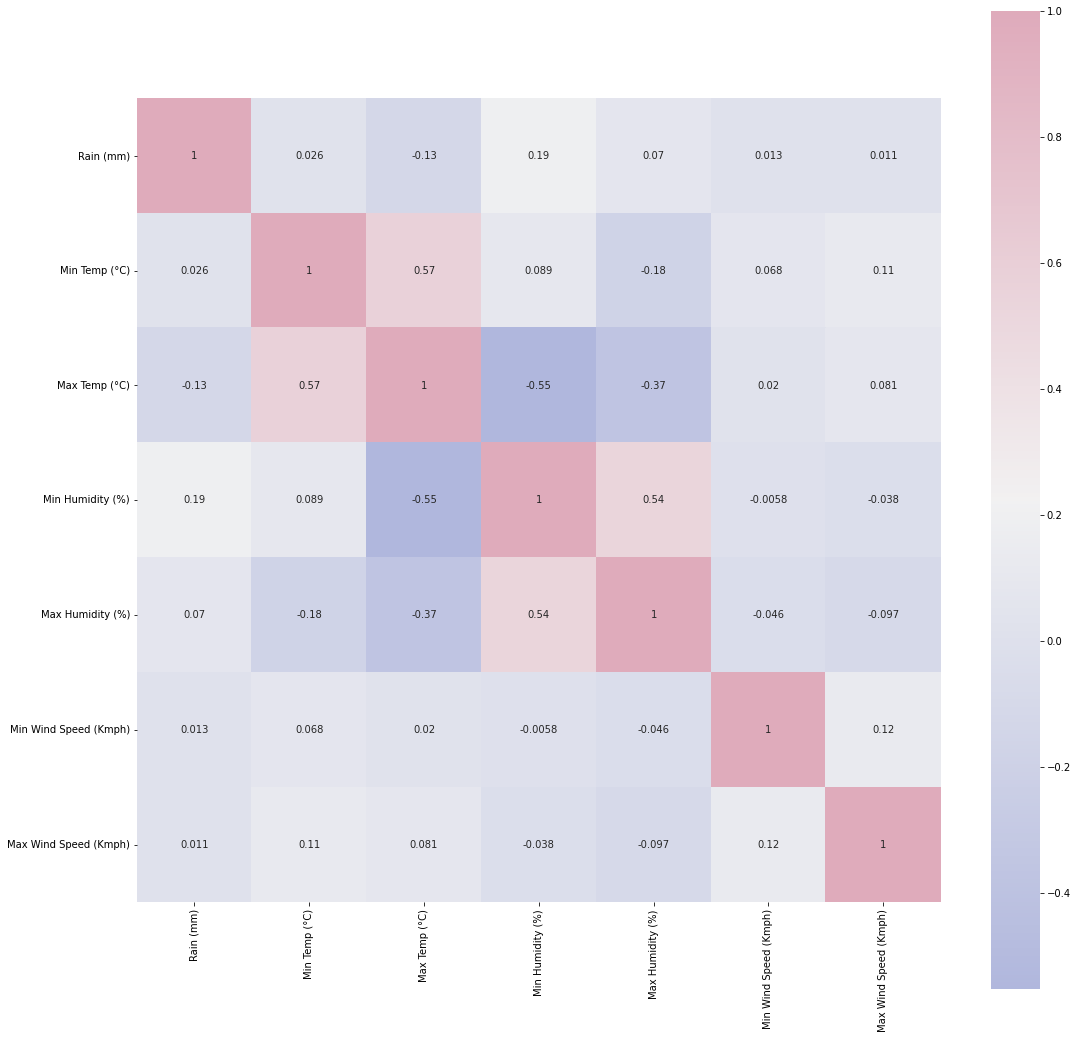

In [6]:
corrmat = data.corr()
cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True)

In [7]:
data['Date']= pd.to_datetime(data["Date"])
#Creating a collumn of year
data['year'] = data.Date.dt.year

# function to encode datetime into cyclic parameters. 
#As I am planning to use this data in a neural network I prefer the months and days in a cyclic continuous feature. 

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

data['month'] = data.Date.dt.month
data = encode(data, 'month', 12)

data['day'] = data.Date.dt.day
data = encode(data, 'day', 31)

data.head()

,District,Mandal,Date,Rain (mm),Min Temp (°C),Max Temp (°C),Min Humidity (%),Max Humidity (%),Min Wind Speed (Kmph),Max Wind Speed (Kmph),RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,Adilabad,Bheempoor,2021-01-01,0.0,10.1,30.0,37.8,95.7,0.0,3.1,No,2021,1,0.5,0.866025,1,0.201299,0.979530
1,Adilabad,Bheempoor,2021-01-02,0.0,11.7,29.9,40.6,96.6,0.0,2.2,No,2021,1,0.5,0.866025,2,0.394356,0.918958
2,Adilabad,Bheempoor,2021-01-03,0.0,10.4,30.4,45.8,97.0,0.0,2.2,No,2021,1,0.5,0.866025,3,0.571268,0.820763
3,Adilabad,Bheempoor,2021-01-04,0.0,13.1,30.5,38.4,96.4,0.0,2.0,No,2021,1,0.5,0.866025,4,0.724793,0.688967
4,Adilabad,Bheempoor,2021-01-05,0.0,13.4,29.8,50.7,97.0,0.0,2.0,No,2021,1,0.5,0.866025,5,0.848644,0.528964


Text(0.5, 0, 'Days In Year')

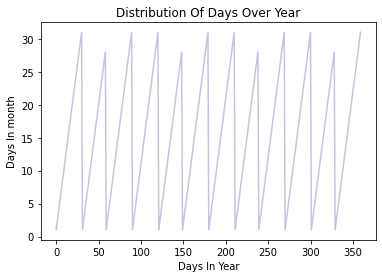

In [8]:
section = data[:360] 
tm = section["day"].plot(color="#C2C4E2")
tm.set_title("Distribution Of Days Over Year")
tm.set_ylabel("Days In month")
tm.set_xlabel("Days In Year")


Text(0.5, 0, 'Sine Encoded Months')

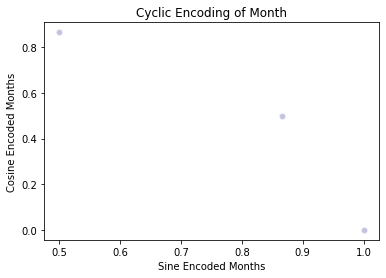

In [9]:
cyclic_month = sns.scatterplot(x="month_sin",y="month_cos",data=data, color="#C2C4E2")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")

Text(0.5, 0, 'Sine Encoded Day')

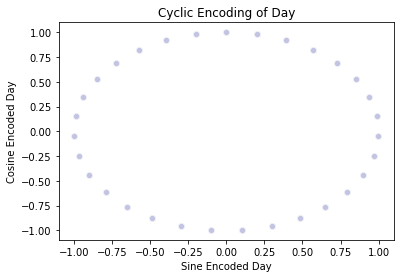

In [10]:
cyclic_day = sns.scatterplot(x='day_sin',y='day_cos',data=data, color="#C2C4E2")
cyclic_day.set_title("Cyclic Encoding of Day")
cyclic_day.set_ylabel("Cosine Encoded Day")
cyclic_day.set_xlabel("Sine Encoded Day")

In [11]:
s = (data.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['District', 'Mandal', 'RainTomorrow']


In [12]:
# Filling missing values with mode of the column in value

for i in object_cols:
    data[i].fillna(data[i].mode()[0], inplace=True)
for i in object_cols:
    print(i, data[i].isnull().sum())

District 0
Mandal 0
RainTomorrow 0


In [13]:
t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['Rain (mm)', 'Min Temp (°C)', 'Max Temp (°C)', 'Min Humidity (%)', 'Max Humidity (%)', 'Min Wind Speed (Kmph)', 'Max Wind Speed (Kmph)', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [14]:
for i in num_cols:
    print(i, data[i].isnull().sum())
for i in num_cols:
    data[i].fillna(data[i].median(), inplace=True)
    
data.info()

Rain (mm) 0
Min Temp (°C) 0
Max Temp (°C) 0
Min Humidity (%) 1
Max Humidity (%) 1
Min Wind Speed (Kmph) 52216
Max Wind Speed (Kmph) 52568
month_sin 0
month_cos 0
day_sin 0
day_cos 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192740 entries, 0 to 192739
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   District               192740 non-null  object        
 1   Mandal                 192740 non-null  object        
 2   Date                   192740 non-null  datetime64[ns]
 3   Rain (mm)              192740 non-null  float64       
 4   Min Temp (°C)          192740 non-null  float64       
 5   Max Temp (°C)          192740 non-null  float64       
 6   Min Humidity (%)       192740 non-null  float64       
 7   Max Humidity (%)       192740 non-null  float64       
 8   Min Wind Speed (Kmph)  192740 non-null  float64       
 9   Max Wind Speed (Kmph)  192740 non-null  fl

##DATA Pre - Processing

In [15]:
label_encoder = LabelEncoder()
for i in object_cols:
    data[i] = label_encoder.fit_transform(data[i])
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192740 entries, 0 to 192739
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   District               192740 non-null  int64         
 1   Mandal                 192740 non-null  int64         
 2   Date                   192740 non-null  datetime64[ns]
 3   Rain (mm)              192740 non-null  float64       
 4   Min Temp (°C)          192740 non-null  float64       
 5   Max Temp (°C)          192740 non-null  float64       
 6   Min Humidity (%)       192740 non-null  float64       
 7   Max Humidity (%)       192740 non-null  float64       
 8   Min Wind Speed (Kmph)  192740 non-null  float64       
 9   Max Wind Speed (Kmph)  192740 non-null  float64       
 10  RainTomorrow           192740 non-null  int64         
 11  year                   192740 non-null  int64         
 12  month                  192740 non-null  int6

In [16]:
features = data.drop(['RainTomorrow', 'Date','day', 'month'], axis=1) # dropping target and extra columns

target = data['RainTomorrow']

#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names) 

features.describe().T
print(features)

        District    Mandal  Rain (mm)  ...  month_cos   day_sin   day_cos
0      -1.841229 -1.377789  -0.097211  ...   1.143919  0.273422  1.447463
1      -1.841229 -1.377789  -0.097211  ...   1.143919  0.542870  1.360554
2      -1.841229 -1.377789  -0.097211  ...   1.143919  0.789785  1.219664
3      -1.841229 -1.377789  -0.097211  ...   1.143919  1.004058  1.030562
4      -1.841229 -1.377789  -0.097211  ...   1.143919  1.176916  0.800990
...          ...       ...        ...  ...        ...       ...       ...
192735  1.844403  1.688004  -0.097211  ...  -1.260433 -1.019115  1.030562
192736  1.844403  1.688004  -0.097211  ...  -1.260433 -0.804842  1.219664
192737  1.844403  1.688004  -0.097211  ...  -1.260433 -0.557927  1.360554
192738  1.844403  1.688004  -0.097211  ...  -1.260433 -0.288479  1.447463
192739  1.844403  1.688004  -0.097211  ...  -1.260433 -0.007528  1.476833

[192740 rows x 14 columns]


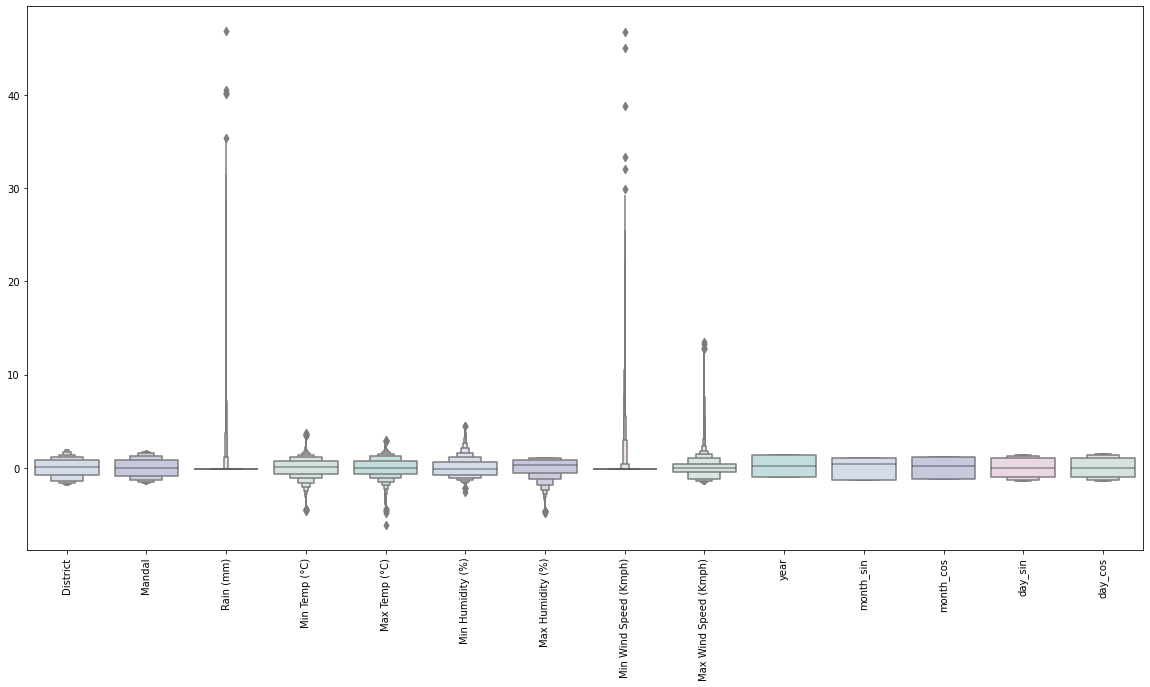

        District    Mandal  Rain (mm)  ...  month_cos   day_sin   day_cos
0      -1.841229 -1.377789  -0.097211  ...   1.143919  0.273422  1.447463
1      -1.841229 -1.377789  -0.097211  ...   1.143919  0.542870  1.360554
2      -1.841229 -1.377789  -0.097211  ...   1.143919  0.789785  1.219664
3      -1.841229 -1.377789  -0.097211  ...   1.143919  1.004058  1.030562
4      -1.841229 -1.377789  -0.097211  ...   1.143919  1.176916  0.800990
...          ...       ...        ...  ...        ...       ...       ...
192735  1.844403  1.688004  -0.097211  ...  -1.260433 -1.019115  1.030562
192736  1.844403  1.688004  -0.097211  ...  -1.260433 -0.804842  1.219664
192737  1.844403  1.688004  -0.097211  ...  -1.260433 -0.557927  1.360554
192738  1.844403  1.688004  -0.097211  ...  -1.260433 -0.288479  1.447463
192739  1.844403  1.688004  -0.097211  ...  -1.260433 -0.007528  1.476833

[192740 rows x 14 columns]


In [17]:
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()
print(features)

In [18]:
#full data for 
features["RainTomorrow"] = target
print(features)
#Dropping with outlier

#features = features[(features["Min Temp (°C)"]<27)&(features["Min Temp (°C)"]>10)]
#features = features[(features["Max Temp (°C)"]<45)&(features["Max Temp (°C)"]>30)]
#features = features[(features["Rain (mm)"]<4.5)]
#features = features[(features["Min Wind Speed (Kmph)"]<2)]
#features = features[(features["Max Wind Speed (Kmph)"]>1.0)]
#features = features[(features["Min Humidity (%)"]>10)]
#features = features[(features["Max Humidity (%)"]<90)]

features = features[(features["Min Temp (°C)"]<2.3)&(features["Min Temp (°C)"]>-2.3)]
features = features[(features["Max Temp (°C)"]<2.3)&(features["Max Temp (°C)"]>-2)]
features = features[(features["Rain (mm)"]<4.5)]
features = features[(features["Min Wind Speed (Kmph)"]<4)]
features = features[(features["Max Wind Speed (Kmph)"]<2.5)]
features = features[(features["Min Humidity (%)"]>-3)]
features = features[(features["Max Humidity (%)"]>-2.2)]



features.shape

        District    Mandal  Rain (mm)  ...   day_sin   day_cos  RainTomorrow
0      -1.841229 -1.377789  -0.097211  ...  0.273422  1.447463             0
1      -1.841229 -1.377789  -0.097211  ...  0.542870  1.360554             0
2      -1.841229 -1.377789  -0.097211  ...  0.789785  1.219664             0
3      -1.841229 -1.377789  -0.097211  ...  1.004058  1.030562             0
4      -1.841229 -1.377789  -0.097211  ...  1.176916  0.800990             0
...          ...       ...        ...  ...       ...       ...           ...
192735  1.844403  1.688004  -0.097211  ... -1.019115  1.030562             0
192736  1.844403  1.688004  -0.097211  ... -0.804842  1.219664             0
192737  1.844403  1.688004  -0.097211  ... -0.557927  1.360554             0
192738  1.844403  1.688004  -0.097211  ... -0.288479  1.447463             0
192739  1.844403  1.688004  -0.097211  ... -0.007528  1.476833             0

[192740 rows x 15 columns]


(171251, 15)

## Model Building

In [19]:
X = features.drop(["RainTomorrow"], axis=1)
y = features["RainTomorrow"]

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X.shape

(171251, 14)

In [20]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 14))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.0000009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 16, epochs = 10, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/10
6850/6850 [==============================] - 14s 2ms/step - loss: 0.6914 - accuracy: 0.9720 - val_loss: 0.6896 - val_accuracy: 0.9722
Epoch 2/10
6850/6850 [==============================] - 13s 2ms/step - loss: 0.6877 - accuracy: 0.9725 - val_loss: 0.6857 - val_accuracy: 0.9722
Epoch 3/10
6850/6850 [==============================] - 13s 2ms/step - loss: 0.6836 - accuracy: 0.9725 - val_loss: 0.6813 - val_accuracy: 0.9722
Epoch 4/10
6850/6850 [==============================] - 14s 2ms/step - loss: 0.6787 - accuracy: 0.9725 - val_loss: 0.6758 - val_accuracy: 0.9722
Epoch 5/10
6850/6850 [==============================] - 13s 2ms/step - loss: 0.6725 - accuracy: 0.9725 - val_loss: 0.6689 - val_accuracy: 0.9722
Epoch 6/10
6850/6850 [==============================] - 14s 2ms/step - loss: 0.6646 - accuracy: 0.9725 - val_loss: 0.6600 - val_accuracy: 0.9722
Epoch 7/10
6850/6850 [==============================] - 14s 2ms/step - loss: 0.6544 - accuracy: 0.9725 - val_loss: 0.6481 - val_ac

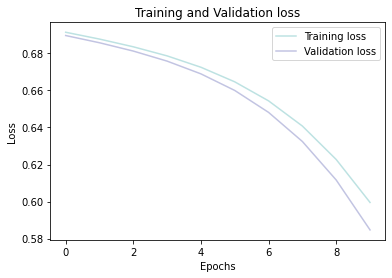

In [21]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

In [22]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

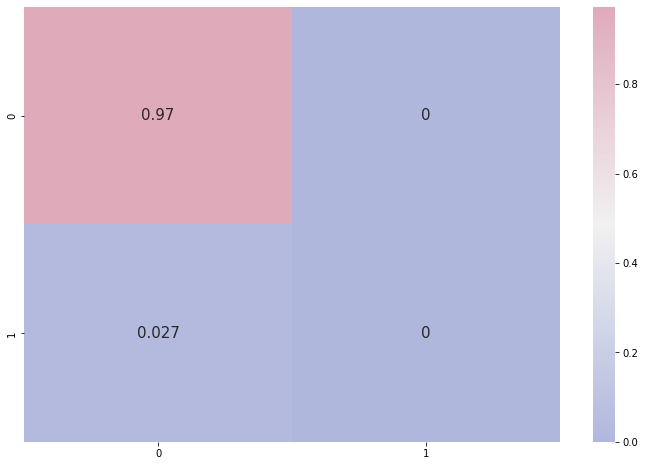

In [23]:
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     33318
           1       0.00      0.00      0.00       933

    accuracy                           0.97     34251
   macro avg       0.49      0.50      0.49     34251
weighted avg       0.95      0.97      0.96     34251



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
